<a href="https://colab.research.google.com/github/omorros/SmartFoodAI/blob/main/SmartFoodAI_ModelDeployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================================
# CHECK ENVIRONMENT & GPU
# ==============================================================

import tensorflow as tf, platform, sys, os, random, numpy as np
print("TensorFlow:", tf.__version__)
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("GPU devices:", tf.config.list_physical_devices('GPU'))

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


TensorFlow: 2.19.0
Python: 3.12.12
OS: Linux-6.6.105+-x86_64-with-glibc2.35
GPU devices: []


In [2]:
# ==============================================================
# KAGGLE API SETUP (SAFE)
# ==============================================================

from google.colab import files
print("Please upload your kaggle.json (Kaggle → Account → Create API Token)")
uploaded = files.upload()

from IPython.display import clear_output
clear_output()

os.makedirs('/root/.kaggle', exist_ok=True)
os.replace('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)
print("Kaggle API key configured successfully!")



Kaggle API key configured successfully!


In [5]:
# ==============================================================
# DOWNLOAD FRUITS-360 DATASET
# ==============================================================

!pip install -q kaggle

if not os.path.exists("/content/fruits_dataset"):
    print("Downloading dataset from Kaggle...")
    !kaggle datasets download -d moltean/fruits -p /content
    !unzip -q /content/fruits.zip -d /content/fruits_dataset
else:
    print("Dataset already exists — skipping download.")


Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 4.53G/4.54G [01:05<00:00, 36.9MB/s]
100% 4.54G/4.54G [01:06<00:00, 73.8MB/s]


In [3]:
# ==============================================================
# DEFINE PATHS
# ==============================================================

BASE_DIR = "/content/fruits_dataset/fruits-360_100x100/fruits-360"
TRAIN_DIR = os.path.join(BASE_DIR, "Training")
TEST_DIR  = os.path.join(BASE_DIR, "Test")

print("Train path:", TRAIN_DIR)
print("Test  path:", TEST_DIR)


Train path: /content/fruits_dataset/fruits-360_100x100/fruits-360/Training
Test  path: /content/fruits_dataset/fruits-360_100x100/fruits-360/Test


In [7]:
# ==============================================================
# INSPECT DATASET STRUCTURE
# ==============================================================

subdirs = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print("Example classes:", subdirs[:10])
print("Total fruit classes:", len(subdirs))


Example classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']
Total fruit classes: 225


In [8]:
# ==============================================================
# IMAGE GENERATORS (AUGMENTATION)
# ==============================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (100, 100)
BATCH = 32
VAL_SPLIT = 0.2

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
print("Classes detected:", NUM_CLASSES)


Found 94134 images belonging to 225 classes.
Found 23442 images belonging to 225 classes.
Found 39212 images belonging to 225 classes.
Classes detected: 225


In [9]:
# ==============================================================
# BUILD CNN
# ==============================================================

from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 225)            │        29,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,760,801 (6.72 MB)

 Trainable params: 1,760,801 (6.72 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# ==============================================================
# COMPILE & CALLBACKS
# ==============================================================

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CHK_PATH = "/content/best_fruits_cnn.keras"
early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
chkpt = ModelCheckpoint(CHK_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

callbacks = [early, chkpt]



In [11]:
# ==============================================================
# TRAIN THE CNN
# ==============================================================

EPOCHS = 10

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.1896 - loss: 3.4691
Epoch 1: val_accuracy improved from -inf to 0.76977, saving model to /content/best_fruits_cnn.keras
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 2441s 829ms/step - accuracy: 0.1896 - loss: 3.4687 - val_accuracy: 0.7698 - val_loss: 0.7920
Epoch 2/10
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.5678 - loss: 1.3381
Epoch 2: val_accuracy improved from 0.76977 to 0.84110, saving model to /content/best_fruits_cnn.keras
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 2421s 823ms/step - accuracy: 0.5678 - loss: 1.3381 - val_accuracy: 0.8411 - val_loss: 0.5327
Epoch 3/10
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.6686 - loss: 0.9986
Epoch 3: val_accuracy improved from 0.84110 to 0.88337, saving model to /content/best_fruits_cnn.keras
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 2330s 792ms/step - accuracy: 0.6686 - loss: 0.9986 - val_accuracy: 0.8834 - val_loss: 0.4085
Epoch 4/10
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/s

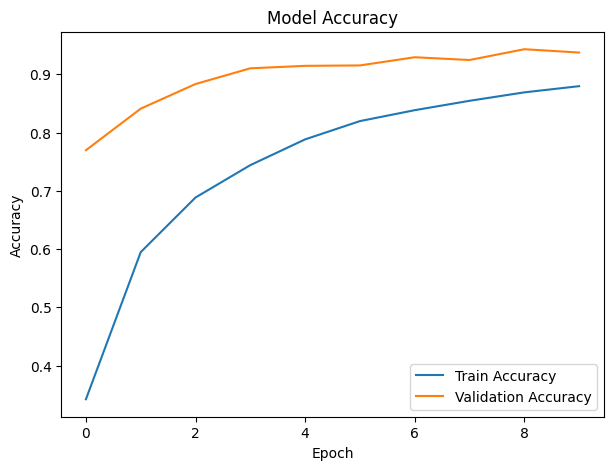

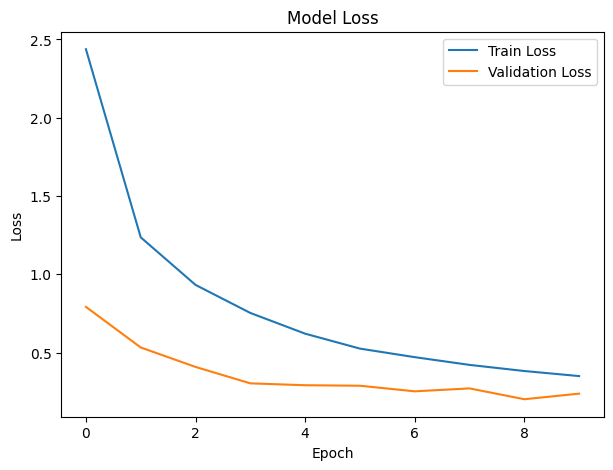

In [12]:
# ==============================================================
# VISUALIZE TRAINING
# ==============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()


In [13]:
# ==============================================================
# FINAL TEST EVALUATION
# ==============================================================

from IPython.display import Markdown

test_loss, test_acc = model.evaluate(test_gen, verbose=0)

Markdown(f"### Final Model Performance\n"
         f"- **Test Accuracy:** {test_acc * 100:.2f}%\n"
         f"- **Test Loss:** {test_loss:.4f}")



### Final Model Performance
- **Test Accuracy:** 96.30%
- **Test Loss:** 0.1592

In [14]:
# ==============================================================
# SAVE MODEL (.keras FORMAT) + LABEL MAP
# ==============================================================

import json

MODEL_PATH = "/content/fruits_classifier.keras"
model.save(MODEL_PATH)

class_indices = train_gen.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}

with open("/content/fruits_labels.json", "w") as f:
    json.dump(idx_to_class, f, indent=2)

print("Model saved to:", MODEL_PATH)


Model saved to: /content/fruits_classifier.keras


In [15]:
# ==============================================================
# SINGLE IMAGE PREDICTION
# ==============================================================

from tensorflow.keras.preprocessing import image
import numpy as np, json

with open("/content/fruits_labels.json") as f:
    idx_to_class = json.load(f)

fruit_folder = os.listdir(TEST_DIR)[0]
img_name = os.listdir(os.path.join(TEST_DIR, fruit_folder))[0]
img_path = os.path.join(TEST_DIR, fruit_folder, img_name)
print("Image path:", img_path)

img = image.load_img(img_path, target_size=IMG_SIZE)
x = image.img_to_array(img)/255.0
x = np.expand_dims(x, axis=0)

probs = model.predict(x)
pred_idx = int(np.argmax(probs))
pred_label = idx_to_class[str(pred_idx)] if isinstance(list(idx_to_class.keys())[0], str) else idx_to_class[pred_idx]
print(f"Predicted class: {pred_label} | Confidence: {probs[0][pred_idx]:.2f}")


Image path: /content/fruits_dataset/fruits-360_100x100/fruits-360/Test/Mango Red 1/r_54_100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Predicted class: Mango Red 1 | Confidence: 1.00


In [17]:
# ==============================================================
# RELOAD MODEL & VERIFY RESULTS
# ==============================================================

from tensorflow.keras.models import load_model
import json

# Load model
model = load_model("/content/fruits_classifier.keras")
print("Model reloaded successfully.")

# Reload labels
with open("/content/fruits_labels.json") as f:
    idx_to_class = json.load(f)
print("Labels reloaded.")

# Recreate test generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)

# Evaluate again
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
Markdown(f"### Reloaded Model Performance\n- **Accuracy:** {test_acc*100:.2f}%\n- **Loss:** {test_loss:.4f}")


Model reloaded successfully.
Labels reloaded.
Found 39212 images belonging to 225 classes.


### Reloaded Model Performance
- **Accuracy:** 96.30%
- **Loss:** 0.1592

In [18]:
# ==============================================================
# SAVE TRAINED MODEL SAFELY TO GOOGLE DRIVE
# ==============================================================

from google.colab import drive
import json, os

# Mount Google Drive
drive.mount('/content/drive')

# Create folder for SmartFoodAI project
SAVE_DIR = "/content/drive/MyDrive/SmartFoodAI"
os.makedirs(SAVE_DIR, exist_ok=True)

# Define paths
MODEL_PATH = os.path.join(SAVE_DIR, "fruits_classifier.keras")
LABELS_PATH = os.path.join(SAVE_DIR, "fruits_labels.json")

# Save model and labels
model.save(MODEL_PATH)

class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

with open(LABELS_PATH, "w") as f:
    json.dump(idx_to_class, f, indent=2)

print("Model saved permanently at:", MODEL_PATH)
print("Labels saved at:", LABELS_PATH)


Mounted at /content/drive
Model saved permanently at: /content/drive/MyDrive/SmartFoodAI/fruits_classifier.keras
Labels saved at: /content/drive/MyDrive/SmartFoodAI/fruits_labels.json


In [19]:
!ls -lh /content/drive/MyDrive/SmartFoodAI/

total 21M
-rw------- 1 root root  21M Oct 31 16:36 fruits_classifier.keras
-rw------- 1 root root 5.3K Oct 31 16:36 fruits_labels.json


In [20]:
# ==============================================================
# RELOAD TRAINED MODEL FROM GOOGLE DRIVE
# ==============================================================

from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model
import json

MODEL_PATH = "/content/drive/MyDrive/SmartFoodAI/fruits_classifier.keras"
LABELS_PATH = "/content/drive/MyDrive/SmartFoodAI/fruits_labels.json"

model = load_model(MODEL_PATH)
print("Model loaded successfully.")

with open(LABELS_PATH) as f:
    idx_to_class = json.load(f)
print("Labels loaded successfully. Classes:", len(idx_to_class))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully.
Labels loaded successfully. Classes: 225


In [21]:
from google.colab import files
files.download("/content/drive/MyDrive/SmartFoodAI/fruits_classifier.keras")
files.download("/content/drive/MyDrive/SmartFoodAI/fruits_labels.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>